# Feature Engineering and Advanced Models
This notebook implements advanced feature engineering (clustering) and tests XGBoost, LightGBM, CatBoost, and Stacking models.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

sns.set_style('whitegrid')

In [26]:
# Load Data
df = pd.read_csv('../data/clean/housing_cleaned-geo.csv')

# Preprocessing
df['transfer_date'] = pd.to_datetime(df['transfer_date'])
df = df[df['transfer_date'].dt.year >= 2024]
df = df.sort_values(by='transfer_date').reset_index(drop=True)

# Log Price
df['log_price'] = np.log1p(df['price'])

In [27]:
# 1. Distance to Centres (Existing)
CENTRES_OSGB = {
    'bhm': (406000, 286000), 'cov': (433000, 279000), 'lei': (458500, 306000),
    'not': (457119, 340206), 'der': (435187, 336492), 'sto': (488000, 347000),
    'wol': (391500, 298500), 'sol': (415000, 279000)
}
for key, (E0, N0) in CENTRES_OSGB.items():
    df[f'dist_{key}_km'] = np.hypot(df['oseast1m'] - E0, df['osnrth1m'] - N0) / 1000.0
df['min_dist_to_retail_centre_km'] = df[[f'dist_{key}_km' for key in CENTRES_OSGB]].min(axis=1)
df = df.drop(columns=[f'dist_{key}_km' for key in CENTRES_OSGB])

# 2. Location Clustering (New)
# Create clusters based on coordinates to capture spatial pockets
kmeans = KMeans(n_clusters=20, random_state=42, n_init=10)
df['location_cluster'] = kmeans.fit_predict(df[['oseast1m', 'osnrth1m']])
df['location_cluster'] = df['location_cluster'].astype(str) # Treat as categorical

In [31]:
df.describe()

,price,transfer_date,new_build,IMD_Decile,IMD_Rank,total_floor_area,year,energy_band_num,is_new_build,is_new_build_energy_band_num,...,new_build_energy_band_num,property_type_order,lat,long,oseast1m,osnrth1m,oac11_name,ruc21_name,imd2019_rank,min_dist_to_retail_centre_km
count,7084.000000,7084,7084.000000,7084.000000,7084.000000,7084.000000,7084.000000,7084.000000,7084.000000,7084.000000,...,7084.000000,7084.000000,7084.000000,7084.000000,7084.000000,7084.000000,0.0,0.0,7084.000000,7084.000000
mean,284681.321993,2025-05-06 22:03:43.602484736,0.043055,5.948193,17914.329334,92.481100,2024.820299,4.318746,0.043055,0.262564,...,0.262564,2.871965,52.633830,-1.718626,419111.199887,304107.705675,NaN,NaN,17951.901750,17.511846
min,75500.000000,2024-01-04 00:00:00,0.000000,1.000000,146.000000,41.200000,2024.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,51.990874,-2.599562,359220.000000,232574.000000,NaN,NaN,146.000000,0.233041
25%,192000.000000,2025-03-07 00:00:00,0.000000,4.000000,10305.500000,72.000000,2025.000000,4.000000,0.000000,0.000000,...,0.000000,2.000000,52.433073,-2.034174,397807.000000,281777.500000,NaN,NaN,10385.000000,6.764925
50%,255000.000000,2025-07-14 00:00:00,0.000000,6.000000,18725.000000,85.635000,2025.000000,4.000000,0.000000,0.000000,...,0.000000,3.000000,52.577958,-1.781203,414971.000000,297942.000000,NaN,NaN,18785.500000,13.644219
75%,342000.000000,2025-08-01 00:00:00,0.000000,8.000000,25918.000000,106.000000,2025.000000,5.000000,0.000000,0.000000,...,0.000000,4.000000,52.807861,-1.431275,438398.250000,323417.500000,NaN,NaN,25907.000000,23.788924
max,948500.000000,2025-08-29 00:00:00,1.000000,10.000000,32825.000000,222.000000,2025.000000,7.000000,1.000000,7.000000,...,7.000000,4.000000,53.472240,-0.741242,485040.000000,397277.000000,NaN,NaN,32825.000000,69.323193
std,135435.790547,NaN,0.202995,2.809395,9228.196969,31.167557,0.383965,1.010762,0.202995,1.243003,...,1.243003,0.906069,0.288215,0.366406,24770.644983,32079.809217,NaN,NaN,9202.453131,13.875610


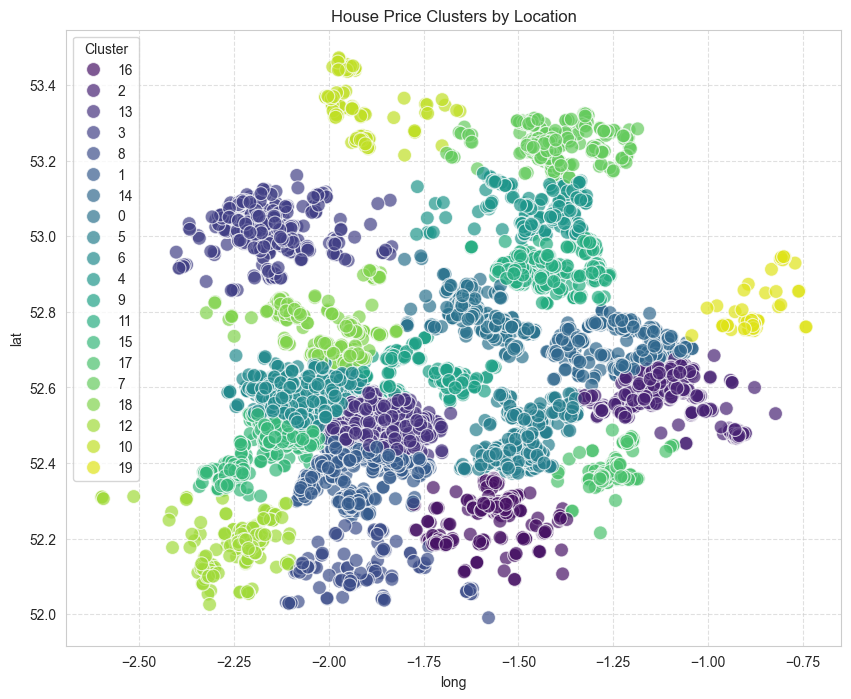

In [37]:
# plot location clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='long', y='lat', hue='location_cluster', data=df, palette='viridis', s=100, alpha=0.7)
plt.title('House Price Clusters by Location')
plt.xlabel('long')
plt.ylabel('lat')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Cluster')
plt.show()


In [38]:
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

y_train = train_df['log_price']
y_test = test_df['log_price']
X_train = train_df.drop(columns=['log_price', 'price', 'transfer_date'])
X_test = test_df.drop(columns=['log_price', 'price', 'transfer_date'])

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (5667, 50), Test shape: (1417, 50)


In [39]:
# Identify columns
num_feats = ['log_total_floor_area', 'IMD_Rank', 'oseast1m', 'osnrth1m', 'min_dist_to_retail_centre_km', 'energy_band_num']
cat_feats = ['property_type', 'ruc21', 'location_cluster'] # Added location_cluster
bin_feats = ['new_build', 'is_leasehold']

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_feats),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_feats),
        ('bin', 'passthrough', bin_feats)
    ],
    remainder='drop'
)

In [40]:
# XGBoost (Optimized)
xgb_params = {
    'n_estimators': 200,
    'learning_rate': 0.1,
    'max_depth': 6,
    'gamma': 0.1,
    'random_state': 42,
    'n_jobs': -1
}
xgb_model = XGBRegressor(**xgb_params)

# LightGBM
lgbm_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}
lgbm_model = LGBMRegressor(**lgbm_params)

# CatBoost
cat_params = {
    'iterations': 500,
    'learning_rate': 0.05,
    'depth': 6,
    'random_seed': 42,
    'verbose': 0,
    'allow_writing_files': False
}
cat_model = CatBoostRegressor(**cat_params)

# Stacking
estimators = [
    ('xgb', xgb_model),
    ('lgbm', lgbm_model),
    ('cat', cat_model)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(),
    n_jobs=-1
)

models = {
    'XGBoost_Optimized': xgb_model,
    'LightGBM': lgbm_model,
    'CatBoost': cat_model,
    'Stacking': stacking_model
}

In [41]:
def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    y_pred_train = pipeline.predict(X_train)
    print(f"R2 Score: {r2_score(y_train, y_pred_train):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_pred_train):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_train, y_pred_train):.3f}")
    print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.3f}")
    print("\n")

    print("* Test Set")
    y_pred_test = pipeline.predict(X_test)
    print(f"R2 Score: {r2_score(y_test, y_pred_test):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_test):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_test):.3f}")
    print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.3f}")
    print("\n")

    # Calculate MAE in GBP
    y_train_gbp = np.expm1(y_train)
    y_pred_train_gbp = np.expm1(y_pred_train)
    y_test_gbp = np.expm1(y_test)
    y_pred_test_gbp = np.expm1(y_pred_test)

    mae_train_gbp = mean_absolute_error(y_train_gbp, y_pred_train_gbp)
    mae_test_gbp = mean_absolute_error(y_test_gbp, y_pred_test_gbp)

    print(f"The train set Mean Absolute Error in GBP: {mae_train_gbp:,.0f}")
    print(f"The test  set Mean Absolute Error in GBP: {mae_test_gbp:,.0f}")
    print("\n")

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    pipeline = Pipeline([
        ('pre', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    
    print(f"Regression Model Performance - {name}")
    print("Note the MAE and MSE are in log(GBP) not GBP")
    regression_performance(X_train, y_train, X_test, y_test, pipeline)
    
    # Return metrics for summary table (using Test set GBP for consistency with previous summary)
    y_pred = pipeline.predict(X_test)
    y_test_gbp = np.expm1(y_test)
    y_pred_gbp = np.expm1(y_pred)
    
    r2 = r2_score(y_test_gbp, y_pred_gbp)
    mae = mean_absolute_error(y_test_gbp, y_pred_gbp)
    rmse = np.sqrt(mean_squared_error(y_test_gbp, y_pred_gbp))
    
    return {'name': name, 'r2': r2, 'mae': mae, 'rmse': rmse, 'pipeline': pipeline}

results = []
for name, model in models.items():
    res = evaluate_model(name, model, X_train, y_train, X_test, y_test)
    results.append(res)

Regression Model Performance - XGBoost_Optimized
Note the MAE and MSE are in log(GBP) not GBP
Model Evaluation 

* Train Set
R2 Score: 0.833
Mean Absolute Error: 0.133
Mean Squared Error: 0.033
Root Mean Squared Error: 0.180


* Test Set
R2 Score: 0.788
Mean Absolute Error: 0.154
Mean Squared Error: 0.045
Root Mean Squared Error: 0.212


The train set Mean Absolute Error in GBP: 36,407
The test  set Mean Absolute Error in GBP: 42,707


Regression Model Performance - LightGBM
Note the MAE and MSE are in log(GBP) not GBP
Model Evaluation 

* Train Set
R2 Score: 0.898
Mean Absolute Error: 0.103
Mean Squared Error: 0.020
Root Mean Squared Error: 0.141


* Test Set
R2 Score: 0.787
Mean Absolute Error: 0.156
Mean Squared Error: 0.045
Root Mean Squared Error: 0.212


The train set Mean Absolute Error in GBP: 28,171
The test  set Mean Absolute Error in GBP: 43,081




c:\vs-code-projects\Midlands_House_Prices\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\vs-code-projects\Midlands_House_Prices\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\vs-code-projects\Midlands_House_Prices\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Regression Model Performance - CatBoost
Note the MAE and MSE are in log(GBP) not GBP
Model Evaluation 

* Train Set
R2 Score: 0.823
Mean Absolute Error: 0.137
Mean Squared Error: 0.034
Root Mean Squared Error: 0.185


* Test Set
R2 Score: 0.801
Mean Absolute Error: 0.151
Mean Squared Error: 0.042
Root Mean Squared Error: 0.205


The train set Mean Absolute Error in GBP: 37,467
The test  set Mean Absolute Error in GBP: 41,549


Regression Model Performance - Stacking
Note the MAE and MSE are in log(GBP) not GBP
Model Evaluation 

* Train Set


c:\vs-code-projects\Midlands_House_Prices\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


R2 Score: 0.837
Mean Absolute Error: 0.131
Mean Squared Error: 0.032
Root Mean Squared Error: 0.178


* Test Set


c:\vs-code-projects\Midlands_House_Prices\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


R2 Score: 0.801
Mean Absolute Error: 0.150
Mean Squared Error: 0.042
Root Mean Squared Error: 0.205


The train set Mean Absolute Error in GBP: 35,876
The test  set Mean Absolute Error in GBP: 41,394




c:\vs-code-projects\Midlands_House_Prices\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


                name        r2           mae          rmse
3           Stacking  0.806374  41394.003055  61848.724696
2           CatBoost  0.805230  41549.414153  62031.195634
1           LightGBM  0.793446  43081.346911  63880.184136
0  XGBoost_Optimized  0.788820  42707.051010  64591.455326


c:\vs-code-projects\Midlands_House_Prices\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


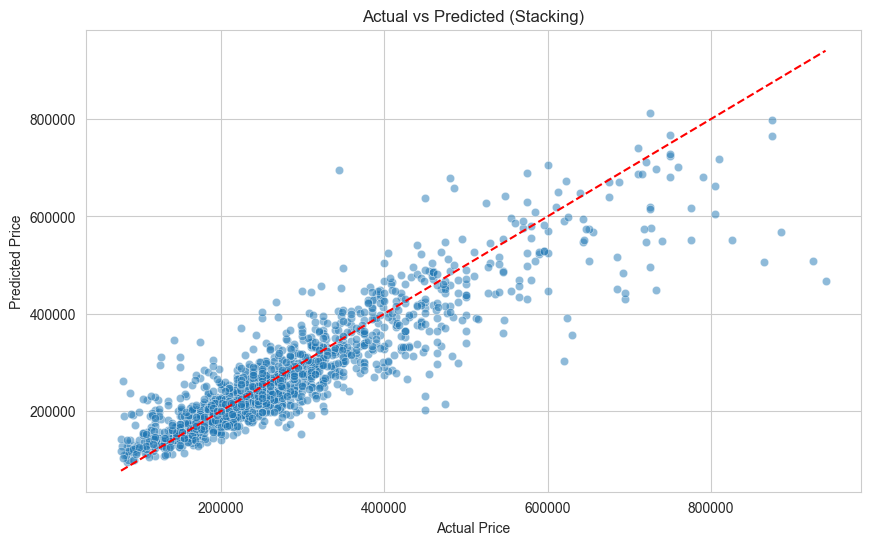

In [42]:
results_df = pd.DataFrame(results).sort_values(by='r2', ascending=False)
print(results_df[['name', 'r2', 'mae', 'rmse']])

# Plot Best Model
best_model_res = results_df.iloc[0]
best_pipeline = best_model_res['pipeline']
y_pred_gbp = np.expm1(best_pipeline.predict(X_test))
y_test_gbp = np.expm1(y_test)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_gbp, y=y_pred_gbp, alpha=0.5)
plt.plot([y_test_gbp.min(), y_test_gbp.max()], [y_test_gbp.min(), y_test_gbp.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f"Actual vs Predicted ({best_model_res['name']})")
plt.show()

# Model Interpretability & Analysis
We will now perform SHAP analysis to understand feature importance and PCA to visualize the data structure.

In [43]:
# Install SHAP if not already installed
%pip install shap

Note: you may need to restart the kernel to use updated packages.


In [44]:
import shap
from sklearn.decomposition import PCA

# Initialize JS for SHAP plots
shap.initjs()

In [45]:
def get_feature_names_from_preprocessor(preprocessor):
    """Return feature names for each transformer within a fitted ColumnTransformer."""
    feature_names = []
    for name, transformer, columns in preprocessor.transformers_:
        if name == 'remainder' or transformer == 'drop':
            continue
        if transformer == 'passthrough':
            feature_names.extend(columns)
            continue
        fitted_transformer = transformer
        # Pipelines expose the final estimator through steps[-1]
        if hasattr(transformer, 'steps') and len(transformer.steps) > 0:
            fitted_transformer = transformer.steps[-1][1]
        if hasattr(fitted_transformer, 'get_feature_names_out'):
            try:
                names = fitted_transformer.get_feature_names_out(columns)
            except TypeError:
                names = fitted_transformer.get_feature_names_out()
        else:
            names = columns
        feature_names.extend(list(names))
    return feature_names

# Neural Network and Target Encoding
We will now implement Target Encoding for high-cardinality features and test a Neural Network (MLPRegressor).

In [46]:
# Install category_encoders if not already installed
%pip install category_encoders

  Using cached category_encoders-2.9.0-py3-none-any.whl.metadata (7.9 kB)
  Using cached patsy-1.0.2-py2.py3-none-any.whl.metadata (3.6 kB)
  Using cached statsmodels-0.14.5-cp312-cp312-win_amd64.whl.metadata (9.8 kB)
Using cached category_encoders-2.9.0-py3-none-any.whl (85 kB)
Using cached patsy-1.0.2-py2.py3-none-any.whl (233 kB)
Using cached statsmodels-0.14.5-cp312-cp312-win_amd64.whl (9.6 MB)

   ---------------------------------------- 0/3 [patsy]
   ---------------------------------------- 0/3 [patsy]
   ---------------------------------------- 0/3 [patsy]
   ---------------------------------------- 0/3 [patsy]
   ---------------------------------------- 0/3 [patsy]
   ---------------------------------------- 0/3 [patsy]
   ---------------------------------------- 0/3 [patsy]
   ---------------------------------------- 0/3 [patsy]
   ---------------------------------------- 0/3 [patsy]
   ---------------------------------------- 0/3 [patsy]
   ----------------------------------

In [47]:
from sklearn.neural_network import MLPRegressor
from category_encoders import TargetEncoder

# Define Target Encoder for high-cardinality features
# We will use 'town_city' and 'district' for target encoding
target_feats = ['town_city', 'district']

# Neural Network Preprocessor
nn_num_feats = ['log_total_floor_area', 'IMD_Rank', 'oseast1m', 'osnrth1m', 'min_dist_to_retail_centre_km', 'energy_band_num']
nn_cat_feats = ['property_type', 'ruc21', 'location_cluster']
nn_target_feats = ['town_city', 'district'] # High cardinality
nn_bin_feats = ['new_build', 'is_leasehold']

nn_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), nn_num_feats),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nn_cat_feats),
        ('target', TargetEncoder(), nn_target_feats),
        ('bin', 'passthrough', nn_bin_feats)
    ],
    remainder='drop'
)

# MLPRegressor
mlp_params = {
    'hidden_layer_sizes': (100, 50),
    'activation': 'relu',
    'solver': 'adam',
    'alpha': 0.0001,
    'batch_size': 'auto',
    'learning_rate': 'constant',
    'learning_rate_init': 0.001,
    'max_iter': 500,
    'random_state': 42,
    'early_stopping': True
}
mlp_model = MLPRegressor(**mlp_params)

# Re-creating X_train/X_test with all necessary columns for NN
X_train_nn = train_df.drop(columns=['log_price', 'price', 'transfer_date'])
X_test_nn = test_df.drop(columns=['log_price', 'price', 'transfer_date'])

print("Evaluating Neural Network (MLPRegressor)...")
evaluate_model('MLPRegressor', mlp_model, X_train_nn, y_train, X_test_nn, y_test)


Evaluating Neural Network (MLPRegressor)...
Regression Model Performance - MLPRegressor
Note the MAE and MSE are in log(GBP) not GBP
Model Evaluation 

* Train Set
R2 Score: 0.768
Mean Absolute Error: 0.158
Mean Squared Error: 0.045
Root Mean Squared Error: 0.212


* Test Set
R2 Score: 0.770
Mean Absolute Error: 0.166
Mean Squared Error: 0.049
Root Mean Squared Error: 0.221


The train set Mean Absolute Error in GBP: 43,375
The test  set Mean Absolute Error in GBP: 45,957




{'name': 'MLPRegressor',
 'r2': 0.7702706853258577,
 'mae': 45957.318285397116,
 'rmse': np.float64(67368.53495675905),
 'pipeline': Pipeline(steps=[('pre',
                  ColumnTransformer(transformers=[('num', StandardScaler(),
                                                   ['log_total_floor_area',
                                                    'IMD_Rank', 'oseast1m',
                                                    'osnrth1m',
                                                    'min_dist_to_retail_centre_km',
                                                    'energy_band_num']),
                                                  ('cat',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse_output=False),
                                                   ['property_type', 'ruc21',
                                                    'location_cluster']),
       

## SHAP Analysis (XGBoost)

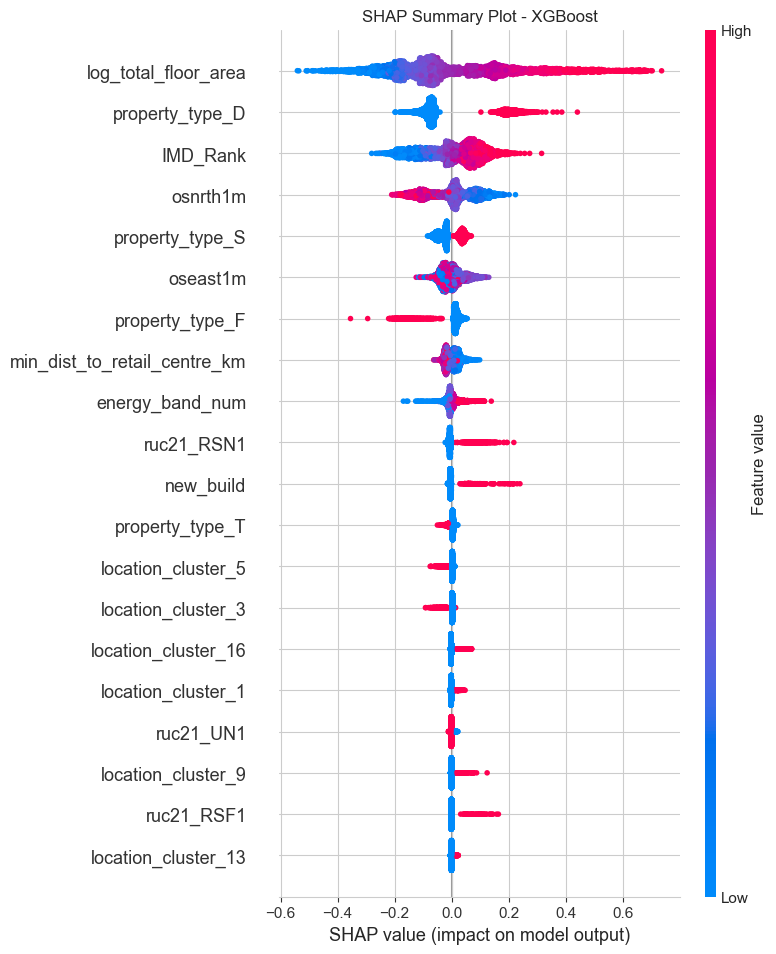

In [48]:
# Use the best model (XGBoost Optimized) for SHAP analysis
best_model = xgb_model
preprocessor = preprocessor # Already defined

# Transform X_train to get the features used by the model
X_train_processed = preprocessor.transform(X_train)
feature_names = get_feature_names_from_preprocessor(preprocessor)

# Create TreeExplainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_processed)

# Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_train_processed, feature_names=feature_names, show=False)
plt.title('SHAP Summary Plot - XGBoost')
plt.show()

## PCA Analysis

Explained Variance Ratio: [0.18636263 0.17226595]
Total Explained Variance (2 Components): 0.359


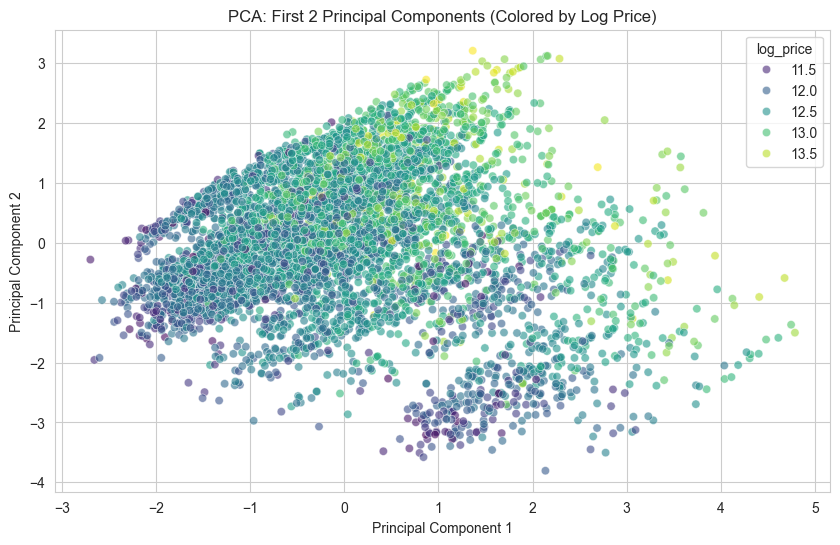

In [49]:
# Apply PCA to the processed (scaled/encoded) training data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_processed)

print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Total Explained Variance (2 Components): {sum(pca.explained_variance_ratio_):.3f}")

# Plot PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train, alpha=0.6, palette='viridis')
plt.title('PCA: First 2 Principal Components (Colored by Log Price)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()